# Impaired Driving Analysis

### 1. Load and Merge Datasets

In [1]:
# ============================================
# 1. Load and Merge Datasets
# ============================================
import pandas as pd
import numpy as np
from scipy import stats

master_path = r"C:\Users\vishs\Capstone Project - Impaired Driving\documentation\Final_Master_Dataset.xlsx"
df = pd.read_excel(master_path)   # <-- FIXED: was `path`

print("Master shape:", df.shape)

# Ensure demographics exist
demo_path = r"C:\Users\vishs\Capstone Project - Impaired Driving\data_raw\Demographic Form.xlsx"
df_demo = pd.read_excel(demo_path)

# Clean demographics
df_demo = df_demo.rename(columns={
    "Participant number": "Participant_ID",
    "What is your age?": "Age",
    "What is your gender?": "Gender",
    "What is your weight? kg": "Weight",
    "What is your height? cm": "Height"
})

df_demo = df_demo[["Participant_ID", "Age", "Gender", "Weight", "Height"]]

# Merge demographics into a new df_final (and then use df_final going forward)
df_final = df.merge(df_demo, on="Participant_ID", how="left")
print("After demographics merge:", df_final.shape)

df_final.head()


Master shape: (416, 21)
After demographics merge: (416, 25)


,Participant_ID,Level,BAC_value,KSS_score,SIM_Steering_mean,SIM_Steering_std,SIM_Throttle_mean,SIM_Brake_mean,SIM_Brake_std,SIM_Speed_mean,...,BIT_ECG_max,Age_x,Gender_x,Weight_x,Height_x,Skin completion,Age_y,Gender_y,Weight_y,Height_y
0,1,1,0.000,2.0,-0.005786,0.041776,0.477899,0.040074,0.059386,77.147633,...,NaN,25,0,88.4,174.5,NaN,25,Male,88.4,174.5
1,1,2,0.023,3.0,-0.004543,0.042611,0.480888,0.033498,0.090019,82.022169,...,1023.0,25,0,88.4,174.5,NaN,25,Male,88.4,174.5
2,1,3,0.043,3.0,-0.004350,0.017384,0.489034,0.005469,0.068838,84.117937,...,1023.0,25,0,88.4,174.5,NaN,25,Male,88.4,174.5
3,1,4,0.065,3.0,-0.004550,0.019206,0.488135,0.003225,0.038490,84.386350,...,960.0,25,0,88.4,174.5,NaN,25,Male,88.4,174.5
4,2,1,0.000,1.0,-0.003673,0.015511,0.443050,0.003502,0.050590,76.212175,...,1022.0,22,0,92.9,181.0,NaN,22,Male,92.9,181.0


### 2. Clean Levels and Remove Invalid Participants

In [2]:
# ============================================
# 2. Clean Levels and Remove Invalid Participants
# ============================================

# Work on a copy of merged data
df = df_final.copy()

# Convert Level to clean string
df["Level_clean"] = df["Level"].astype(str).str.strip()

# Map common codes to 1–4
level_map = {
    "1": 1, "1.0": 1, "Baseline": 1,
    "2": 2, "2.0": 2,
    "3": 3, "3.0": 3,
    "4": 4, "4.0": 4, "Level4": 4, "L4": 4
}

df["Level_num"] = df["Level_clean"].map(level_map)

# Print anything that didn't map
unmapped = sorted(set(df["Level_clean"]) - set(level_map.keys()))
print("Unique Level_clean values that didn't map:", unmapped)

# Use numeric Level
df["Level"] = df["Level_num"]
df.drop(columns=["Level_clean", "Level_num"], inplace=True)

print("Cleaned Level distribution:")
print(df["Level"].value_counts(dropna=False).sort_index())

# Remove bad participants
bad_ids = [67, 68, 69, 70, 91, 92]
df_clean = df[~df["Participant_ID"].isin(bad_ids)].copy()

print("Rows after removing bad IDs:", df_clean.shape[0])
print("Unique participants:", df_clean["Participant_ID"].nunique())


Unique Level_clean values that didn't map: []
Cleaned Level distribution:
Level
1    104
2    104
3    104
4    104
Name: count, dtype: int64
Rows after removing bad IDs: 392
Unique participants: 98


### 3. Participant-level Demographics Summary

In [3]:
# ============================================
# 3. Participant-level demographics summary
# ============================================

demo_cols = ["Participant_ID", "Age", "Gender", "Weight", "Height"]
demo_cols = [c for c in demo_cols if c in df_clean.columns]

df_participants = (
    df_clean[demo_cols]
    .drop_duplicates(subset=["Participant_ID"])
    .copy()
)

print("Number of unique participants:", df_participants["Participant_ID"].nunique())

# Gender distribution (participant-level)
if "Gender" in df_participants.columns:
    print("\nParticipant-level gender distribution:")
    print(df_participants["Gender"].value_counts())

# Age summary (participant-level)
if "Age" in df_participants.columns:
    print("\nParticipant-level age (mean ± std):",
          round(df_participants["Age"].mean(), 2), "±",
          round(df_participants["Age"].std(), 2))


Number of unique participants: 98


### 4. Descriptives + Correlation

In [4]:
import warnings

# Some SciPy versions emit ConstantInputWarning when a column is constant
from scipy.stats import ConstantInputWarning
warnings.filterwarnings("ignore", category=ConstantInputWarning)


try:
    df_base = df_clean.copy()
    print("Using df_clean from notebook. Shape:", df_base.shape)
except NameError:
    df_base = pd.read_excel(
        r"C:\Users\vishs\Capstone Project - Impaired Driving\documentation\FINAL_MASTER_DATASET.xlsx",
        sheet_name="Data"
    )
    print("Loaded from FINAL_MASTER_DATASET.xlsx. Shape:", df_base.shape)


df_num = df_base.select_dtypes(include=[np.number]).copy()
numeric_vars = df_num.columns.tolist()
print("Numeric variables used:", len(numeric_vars))
print(numeric_vars)


desc = df_num.describe().T[["mean", "std"]]
desc.columns = ["Mean", "Std.Dev"]


corr  = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)
pvals = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=float)
N     = pd.DataFrame(index=numeric_vars, columns=numeric_vars, dtype=int)

for i in numeric_vars:
    xi = df_num[i]
    n_i = xi.dropna().shape[0]
    # Diagonal: correlation of a variable with itself
    corr.loc[i, i]  = 1.0
    pvals.loc[i, i] = 0.0
    N.loc[i, i]     = n_i
    
    for j in numeric_vars:
        if j == i:
            continue  # already filled diagonal
        
        pair = df_num[[i, j]].dropna()
        N.loc[i, j] = pair.shape[0]
        
        if pair.shape[0] > 1:
            # Handle both old and new SciPy pearsonr returns
            res = stats.pearsonr(pair[i], pair[j])
            if hasattr(res, "statistic"):
                r_ij = float(res.statistic)
                p_ij = float(res.pvalue)
            else:
                r_ij, p_ij = res
                r_ij = float(r_ij)
                p_ij = float(p_ij)
            
            corr.loc[i, j]  = r_ij
            pvals.loc[i, j] = p_ij
        else:
            corr.loc[i, j]  = np.nan
            pvals.loc[i, j] = np.nan

corr  = corr.round(3)
pvals = pvals.round(4)
N     = N.fillna(0).astype(int)


def make_block(title, matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Build a block:
        first row: [title, "", "", ...]
        then: rows with first column = variable name, rest = matrix values
        then: one blank spacer row
    """
    header = pd.DataFrame([[title] + [""] * len(matrix.columns)],
                          columns=[""] + matrix.columns.tolist())
    
    body = matrix.copy()
    body.insert(0, "", body.index)
    body = body.reset_index(drop=True)
    
    spacer = pd.DataFrame([[""] * len(header.columns)],
                          columns=header.columns)
    
    return pd.concat([header, body, spacer], ignore_index=True)

final_excel = pd.concat([
    make_block("Pearson r", corr),
    make_block("p-value",  pvals),
    make_block("N",        N)
], ignore_index=True)

output_path = r"C:\Users\vishs\Capstone Project - Impaired Driving\documentation\FULL_CORR_TABLE_ALL_VARS.xlsx"
final_excel.to_excel(output_path, index=False)

print("✅ FULL correlation table (ALL numeric vars) saved to:")
print(output_path)


Using df_clean from notebook. Shape: (392, 25)
Numeric variables used: 23
['Participant_ID', 'Level', 'BAC_value', 'KSS_score', 'SIM_Steering_mean', 'SIM_Steering_std', 'SIM_Throttle_mean', 'SIM_Brake_mean', 'SIM_Brake_std', 'SIM_Speed_mean', 'SIM_Speed_std', 'SIM_Speed_max', 'BIT_ECG_mean', 'BIT_ECG_std', 'BIT_ECG_min', 'BIT_ECG_max', 'Age_x', 'Gender_x', 'Weight_x', 'Height_x', 'Age_y', 'Weight_y', 'Height_y']
✅ FULL correlation table (ALL numeric vars) saved to:
C:\Users\vishs\Capstone Project - Impaired Driving\documentation\FULL_CORR_TABLE_ALL_VARS.xlsx


correlation analysis shows that BAC_value and KSS_score are the most influential predictors of impairment (Level), both statistically significant and theoretically aligned with real-world behavior.
Steering variability and speed behavior also show strong correlations with BAC and Level, confirming that driving instability increases with impairment.
Physiological measures like ECG variability contribute meaningfully but are weaker indicators.
DMS glasses/mask signals do not correlate with impairment and were excluded from further modeling.


### 5. Descriptive Statistics

In [5]:

import numpy as np
import pandas as pd

# Pick base dataframe
if "df" in globals():
    df_master = df.copy()
elif "df_clean" in globals():
    df_master = df_clean.copy()
else:
    raise RuntimeError("Please load your master dataset into `df` or `df_clean` before running Cell 6.")

# Ensure Level is numeric
df_master["Level"] = pd.to_numeric(df_master["Level"], errors="coerce")

# Remove any rows with missing Level or BAC/KSS (optional but safer)
df_master = df_master.dropna(subset=["Level", "BAC_value", "KSS_score"])

# Create HighImpair label for later ML use (Level ≥ 3)
df_master["HighImpair"] = (df_master["Level"] >= 3).astype(int)

# Select numeric columns for summary (Gender excluded for now)
numeric_cols = [
    "Level", "BAC_value", "KSS_score",
    "SIM_Steering_std",
    "SIM_Throttle_mean", "SIM_Brake_mean", "SIM_Brake_std",
    "SIM_Speed_mean", "SIM_Speed_std", "SIM_Speed_max",
    "BIT_ECG_mean", "BIT_ECG_std", "BIT_ECG_min", "BIT_ECG_max",
    "Age", "Weight", "Height"
]

numeric_cols = [c for c in numeric_cols if c in df_master.columns]


desc_overall = df_master[numeric_cols].describe().T
desc_overall = desc_overall[["mean", "std", "min", "25%", "50%", "75%", "max"]]
print("Overall Descriptive Statistics:")
display(desc_overall.round(3))


desc_by_level = (
    df_master
    .groupby("Level")[numeric_cols]
    .agg(["mean", "std", "min", "max", "count"])
)

print("\nDescriptive Statistics by Level:")
display(desc_by_level.round(3))


Overall Descriptive Statistics:


,mean,std,min,25%,50%,75%,max
Level,2.482,1.114,1.000,1.000,2.000,3.000,4.000
BAC_value,0.029,0.025,0.000,0.000,0.028,0.046,0.160
KSS_score,3.304,1.517,1.000,2.000,3.000,4.000,9.000
SIM_Steering_std,0.018,0.013,0.013,0.015,0.016,0.017,0.207
SIM_Throttle_mean,0.481,0.051,0.179,0.467,0.493,0.510,0.563
SIM_Brake_mean,0.009,0.014,0.000,0.003,0.004,0.007,0.074
SIM_Brake_std,0.052,0.023,0.000,0.038,0.053,0.066,0.185
SIM_Speed_mean,80.633,10.818,21.472,78.295,84.215,87.843,90.674
SIM_Speed_std,19.303,5.396,5.093,15.384,18.250,22.669,38.291
SIM_Speed_max,104.621,8.999,29.648,100.514,105.139,109.320,134.322



Descriptive Statistics by Level:


Level                    BAC_value                             ...  \
       mean  std min max count      mean    std    min    max count  ...   
Level                                                                ...   
1       1.0  0.0   1   1   104     0.000  0.000  0.000  0.000   104  ...   
2       2.0  0.0   2   2   104     0.019  0.010  0.000  0.047   104  ...   
3       3.0  0.0   3   3   104     0.040  0.014  0.011  0.122   104  ...   
4       4.0  0.0   4   4    99     0.058  0.017  0.021  0.160    99  ...   

      BIT_ECG_min                            BIT_ECG_max                  \
             mean      std  min    max count        mean      std    min   
Level                                                                      
1          91.495  138.572  0.0  416.0    97     946.608   95.055  692.0   
2         166.895  171.560  0.0  497.0    95     900.947  116.616  519.0   
3         200.515  174.198  0.0  431.0    97     884.495  119.115  612.0   
4         173.128  169.392  0.0  435.0    94     879.787  109.285  648.0   

                     
          max count  
Level                
1      1023.0    97  
2      1023.0    95  
3      1023.0    97  
4      1023.0    94  

[4 rows x 70 columns]

### 6. EDA Charts (BAC, KSS, Driving, ECG)

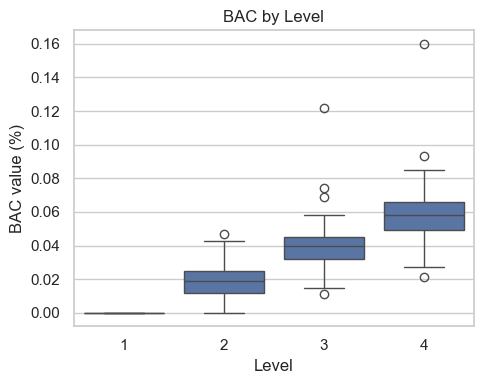

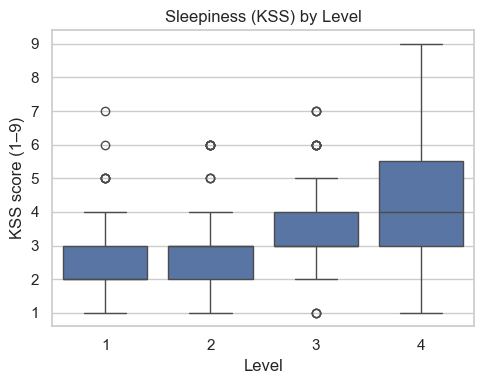

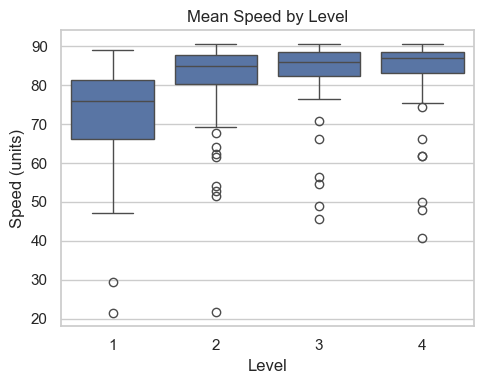

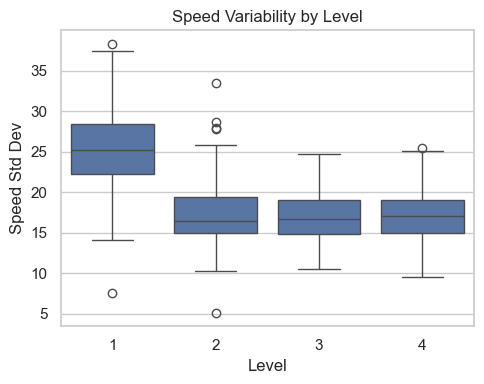

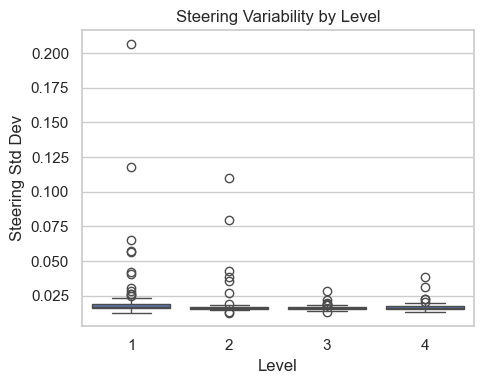

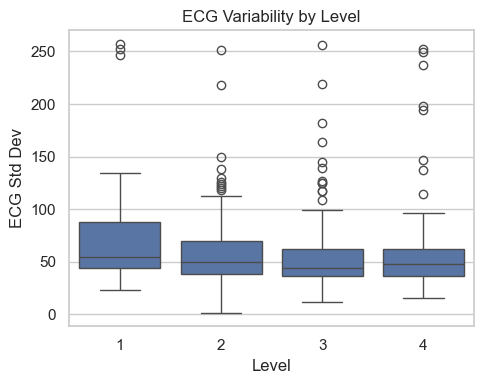

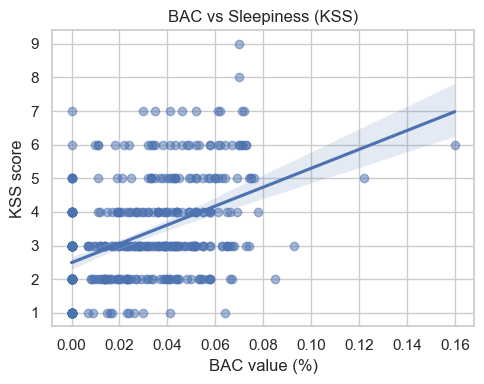

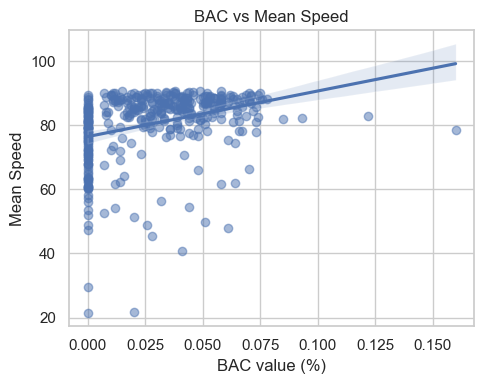

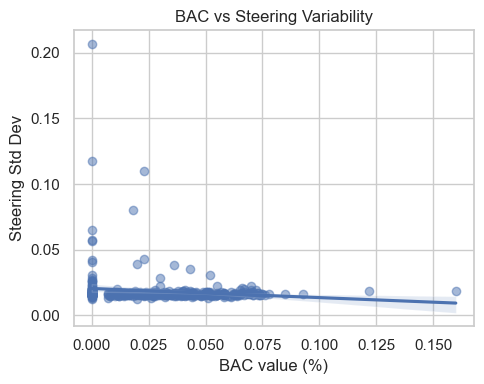

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Helper: simple function for boxplots by Level
def box_by_level(y, title, ylabel):
    if y not in df_master.columns:
        print(f"[Skip] {y} not found in dataframe.")
        return
    plt.figure(figsize=(5,4))
    sns.boxplot(data=df_master, x="Level", y=y)
    plt.title(title)
    plt.xlabel("Level")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


box_by_level("BAC_value", "BAC by Level", "BAC value (%)")
box_by_level("KSS_score", "Sleepiness (KSS) by Level", "KSS score (1–9)")


box_by_level("SIM_Speed_mean", "Mean Speed by Level", "Speed (units)")
box_by_level("SIM_Speed_std", "Speed Variability by Level", "Speed Std Dev")
box_by_level("SIM_Steering_std", "Steering Variability by Level", "Steering Std Dev")


box_by_level("BIT_ECG_std", "ECG Variability by Level", "ECG Std Dev")


def scatter_with_reg(x, y, title, xlabel=None, ylabel=None):
    if x not in df_master.columns or y not in df_master.columns:
        print(f"[Skip] scatter {x} vs {y}: one of the columns is missing.")
        return
    plt.figure(figsize=(5,4))
    sns.regplot(data=df_master, x=x, y=y, scatter_kws={"alpha":0.5})
    plt.title(title)
    plt.xlabel(xlabel or x)
    plt.ylabel(ylabel or y)
    plt.tight_layout()
    plt.show()

# BAC vs KSS
scatter_with_reg("BAC_value", "KSS_score",
                 "BAC vs Sleepiness (KSS)",
                 "BAC value (%)", "KSS score")

# BAC vs Mean Speed
scatter_with_reg("BAC_value", "SIM_Speed_mean",
                 "BAC vs Mean Speed",
                 "BAC value (%)", "Mean Speed")

# BAC vs Steering Variability
scatter_with_reg("BAC_value", "SIM_Steering_std",
                 "BAC vs Steering Variability",
                 "BAC value (%)", "Steering Std Dev")


### 7. ANOVA Across Levels

In [7]:

from scipy import stats
import numpy as np
import pandas as pd

anova_vars = [
    "BAC_value",
    "KSS_score",
    "SIM_Speed_mean",
    "SIM_Speed_std",
    "SIM_Steering_std",
    "BIT_ECG_std"
]

anova_results = []

for var in anova_vars:
    if var not in df_master.columns:
        print(f"[Skip] ANOVA for {var}: not found.")
        continue
    
    # Build list of arrays: one per Level
    groups = []
    levels_present = sorted(df_master["Level"].dropna().unique())
    for lvl in levels_present:
        vals = df_master.loc[df_master["Level"] == lvl, var].dropna().values
        if len(vals) > 1:
            groups.append(vals)
    
    if len(groups) < 2:
        print(f"[Skip] ANOVA for {var}: not enough groups with data.")
        continue
    
    F, p = stats.f_oneway(*groups)
    anova_results.append({
        "Variable": var,
        "F_stat": F,
        "p_value": p
    })

anova_df = pd.DataFrame(anova_results)
print("One-way ANOVA across Levels:")
display(anova_df.round(4))


One-way ANOVA across Levels:


,Variable,F_stat,p_value
0,BAC_value,461.9374,0.0000
1,KSS_score,36.8516,0.0000
2,SIM_Speed_mean,29.1709,0.0000
3,SIM_Speed_std,107.6822,0.0000
4,SIM_Steering_std,3.9416,0.0086
5,BIT_ECG_std,1.1889,0.3137


### 7. Regressions Models

In [8]:
# ============================================
# 🔹 Regression Models (Explanation Models)
#  - Y = SIM_Steering_std
#  - Model 1: BAC
#  - Model 2: BAC + KSS
#  - Model 3: Multimodal (BAC + KSS + Speed + ECG + Throttle + Brake)
# ============================================

import statsmodels.api as sm
import numpy as np
import pandas as pd

# -------- 1) Define variables for each model --------

# Outcome
y_col = "SIM_Steering_std"

# Model 1 predictors
m1_preds = ["BAC_value"]

# Model 2 predictors
m2_preds = ["BAC_value", "KSS_score"]

# Model 3 predictors (you can tweak this list if needed)
m3_preds = [
    "BAC_value",
    "KSS_score",
    "SIM_Speed_mean",
    "BIT_ECG_std",
    "SIM_Throttle_mean",
    "SIM_Brake_std",
]

# -------- 2) Build a clean regression subset (no NaN / Inf) --------
all_cols = [y_col] + list(set(m1_preds + m2_preds + m3_preds))

df_reg = df[all_cols].copy()

# Replace inf / -inf with NaN, then drop rows with any missing
df_reg = df_reg.replace([np.inf, -np.inf], np.nan).dropna(subset=all_cols)

print("Shape of regression dataset after dropping NaN/inf rows:", df_reg.shape)

Y = df_reg[y_col]

X1 = df_reg[m1_preds].copy()
X2 = df_reg[m2_preds].copy()
X3 = df_reg[m3_preds].copy()

# Add constant for intercept
X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)
X3 = sm.add_constant(X3)

# -------- 3) Fit the three models --------
model1 = sm.OLS(Y, X1).fit()
model2 = sm.OLS(Y, X2).fit()
model3 = sm.OLS(Y, X3).fit()

# -------- 4) Show summaries --------
print("=====================================")
print("Model 1: BAC → Steering Variability")
print("=====================================")
display(model1.summary())

print("\n=====================================")
print("Model 2: BAC + KSS → Steering Variability")
print("=====================================")
display(model2.summary())

print("\n=====================================")
print("Model 3: BAC + KSS + Speed + ECG + Throttle + Brake → Steering Variability")
print("=====================================")
display(model3.summary())


Shape of regression dataset after dropping NaN/inf rows: (383, 7)
Model 1: BAC → Steering Variability


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SIM_Steering_std   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.985
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0149
Time:                        15:48:19   Log-Likelihood:                 1113.8
No. Observations:                 383   AIC:                            -2224.
Df Residuals:                     381   BIC:                            -2216.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0204      0.001     19.513      0.000       0.018       0.022
BAC_value     -0.0669      0.027     -2.446      0.015      -0.121      -0.013
==============================================================================
Omnibus:                      647.867   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           221133.031
Skew:                           9.755   Prob(JB):                         0.00
Kurtosis:                     119.087   Cond. No.                         40.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Model 2: BAC + KSS → Steering Variability


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SIM_Steering_std   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.099
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0462
Time:                        15:48:19   Log-Likelihood:                 1114.0
No. Observations:                 383   AIC:                            -2222.
Df Residuals:                     380   BIC:                            -2210.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0198      0.002     12.108      0.000       0.017       0.023
BAC_value     -0.0734      0.031     -2.398      0.017      -0.134      -0.013
KSS_score      0.0002      0.000      0.475      0.635      -0.001       0.001
==============================================================================
Omnibus:                      648.364   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           222342.128
Skew:                           9.768   Prob(JB):                         0.00
Kurtosis:                     119.409   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Model 3: BAC + KSS + Speed + ECG + Throttle + Brake → Steering Variability


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SIM_Steering_std   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.659
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.130
Time:                        15:48:19   Log-Likelihood:                 1115.9
No. Observations:                 383   AIC:                            -2218.
Df Residuals:                     376   BIC:                            -2190.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0240      0.008      2.927      0.004       0.008       0.040
BAC_value            -0.0720      0.032     -2.223      0.027      -0.136      -0.008
KSS_score             0.0002      0.001      0.378      0.706      -0.001       0.001
SIM_Speed_mean        0.0001      0.000      0.563      0.574      -0.000       0.001
BIT_ECG_std       -1.183e-05   1.61e-05     -0.735      0.463   -4.35e-05    1.98e-05
SIM_Throttle_mean    -0.0369      0.055     -0.666      0.506      -0.146       0.072
SIM_Brake_std         0.0523      0.030      1.715      0.087      -0.008       0.112
==============================================================================
Omnibus:                      642.564   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           211467.832
Skew:                           9.606   Prob(JB):                         0.00
Kurtosis:                     116.499   Cond. No.                     8.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 8. ML Modeling 

### Goal: Predict whether a participant is driving impaired by analyzing their driving behavior (speed, throttle, steering) together with physiological signals and self-reported sleepiness.

0 = Low Impairment (Levels 1 & 2)

1 = High Impairment (Levels 3 & 4)

In [9]:
# ============================================
# Machine Learning Models: High vs Low Impairment
# ============================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd

# 9.1 Ensure target exists: HighImpair (Level ≥ 3)
if "HighImpair" not in df_master.columns:
    df_master["HighImpair"] = (df_master["Level"] >= 3).astype(int)

# 9.2 Encode Gender manually if still text
if "Gender" in df_master.columns and df_master["Gender"].dtype == object:
    df_master["Gender_bin"] = df_master["Gender"].map({"Male": 0, "Female": 1})
else:
    df_master["Gender_bin"] = df_master.get("Gender", 0)

# 9.3 Define feature set (behavior + physiology + demographics)
feature_cols = [
    "BAC_value",
    "KSS_score",
    "SIM_Speed_mean",
    "SIM_Speed_std",
    "SIM_Steering_std",
    "SIM_Throttle_mean",
    "SIM_Brake_mean",
    "SIM_Brake_std",
    "BIT_ECG_mean",
    "BIT_ECG_std",
    "Age",
    "Weight",
    "Height",
    "Gender_bin"
]

feature_cols = [c for c in feature_cols if c in df_master.columns]

# Drop any remaining NA in features/target
ml_df = df_master.dropna(subset=feature_cols + ["HighImpair"]).copy()

X = ml_df[feature_cols].values
y = ml_df["HighImpair"].values

# 9.4 Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Helper to train & evaluate a model
def fit_and_eval(name, model):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = np.nan
    
    acc = accuracy_score(y_test, y_pred)
    
    print(f"\n===== {name} =====")
    print(f"Accuracy: {acc:.3f}")
    if not np.isnan(auc):
        print(f"AUC:      {auc:.3f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    return pipe

# 9.5 Train three models
logreg_model = fit_and_eval("Logistic Regression",
                            LogisticRegression(max_iter=1000))

rf_model = fit_and_eval("Random Forest",
                        RandomForestClassifier(
                            n_estimators=200,
                            random_state=42,
                            class_weight="balanced"
                        ))

dt_model = fit_and_eval("Decision Tree",
                        DecisionTreeClassifier(
                            max_depth=5,
                            random_state=42,
                            class_weight="balanced"
                        ))

# 9.6 Optional: Feature importance from Random Forest
if hasattr(rf_model.named_steps["clf"], "feature_importances_"):
    importances = rf_model.named_steps["clf"].feature_importances_
    feat_importance = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": importances
    }).sort_values("Importance", ascending=False)
    
    print("\nRandom Forest Feature Importances:")
    display(feat_importance)



===== Logistic Regression =====
Accuracy: 0.852
AUC:      0.920
Confusion matrix:
[[51  7]
 [10 47]]

Classification report:
              precision    recall  f1-score   support

           0      0.836     0.879     0.857        58
           1      0.870     0.825     0.847        57

    accuracy                          0.852       115
   macro avg      0.853     0.852     0.852       115
weighted avg      0.853     0.852     0.852       115


===== Random Forest =====
Accuracy: 0.870
AUC:      0.912
Confusion matrix:
[[50  8]
 [ 7 50]]

Classification report:
              precision    recall  f1-score   support

           0      0.877     0.862     0.870        58
           1      0.862     0.877     0.870        57

    accuracy                          0.870       115
   macro avg      0.870     0.870     0.870       115
weighted avg      0.870     0.870     0.870       115


===== Decision Tree =====
Accuracy: 0.826
AUC:      0.819
Confusion matrix:
[[47 11]
 [ 9 48]]

Cla

,Feature,Importance
0,BAC_value,0.511703
5,SIM_Throttle_mean,0.106336
2,SIM_Speed_mean,0.081887
3,SIM_Speed_std,0.073538
1,KSS_score,0.051820
9,BIT_ECG_std,0.045314
4,SIM_Steering_std,0.037450
8,BIT_ECG_mean,0.033787
7,SIM_Brake_std,0.032814
6,SIM_Brake_mean,0.025351


In [10]:
# ============================================
# Confusion Matrices + Per-class metrics
# ============================================
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import pandas as pd
import numpy as np

def pretty_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    # 1) Confusion matrix table (like prof's layout)
    cm_df = pd.DataFrame(
        cm,
        index=pd.Index(["0", "1"], name="TRUE"),
        columns=pd.Index(["0", "1"], name="Prediction")
    )

    print(f"\n==============================")
    print(f"{model_name} – Confusion Matrix")
    print(f"==============================")
    display(cm_df)


# ---- Call for each model (re-using X_test, y_test, and trained pipes) ----
y_pred_lr = logreg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

pretty_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
pretty_confusion_matrix(y_test, y_pred_rf, "Random Forest")
pretty_confusion_matrix(y_test, y_pred_dt, "Decision Tree")



Logistic Regression – Confusion Matrix


Prediction,0,1
TRUE,,
0,51,7
1,10,47



Random Forest – Confusion Matrix


Prediction,0,1
TRUE,,
0,50,8
1,7,50



Decision Tree – Confusion Matrix


Prediction,0,1
TRUE,,
0,47,11
1,9,48
